CAR - Cascade of Asymmetric Resonators
===

The code below implements a model of the cochlea developed by Dick Lyon.

It is described in detail in his [book](http://www.machinehearing.org). Page numbers in the code comments refer to the pages of the Author’s 2018 corrected manuscript of this book.

The cochlear model is a cascade of resonators, modelling the properties of the Basilar Membrane (BM). The resonators all look like this:

<img src="./images/CAR.png" alt="CAR" style="width: 300px;"/>

$X$ is the input of the section, coming from the sound source for the first section in the cascade, and from the output $Y$ of the previous section for each of the following sections.
$a_0$ and $c_0$ are are the coefficients of the filter, controlling the resonant frequency of each section. The resonant frequency will be highest for the first section and drop exponentially along the cochlea.
$r$ controls the radius of the poles and zeros and thus the damping.
$h$ controls the distance between the poles and the zeros in the frequency domain.
$g$ adjusts the dc gain.

In [1]:
%matplotlib widget
from pylab import *
from scipy import signal
w = 9.5                             # figure width in inches

First let's set the stimulation parameters:

In [2]:
fs = 48000.0                        # sample frequency
dur = 2                             # simulation duration
npoints = int(fs*dur)               # stimulus length

Next, we create a log-sine-sweep using the *chirp* function from the *scipi.signal* library:

In [3]:
# create a log-sine-sweep
f0 = 20                             # sweep start frequency
f1 = 20000                          # sweep end frequency
t1 = arange(npoints)/fs             # sample times
stimulus = 0.9 * signal.chirp(t1, f0, t1[-1], f1, method='logarithmic', phi=-90)

And this is what it looks like:

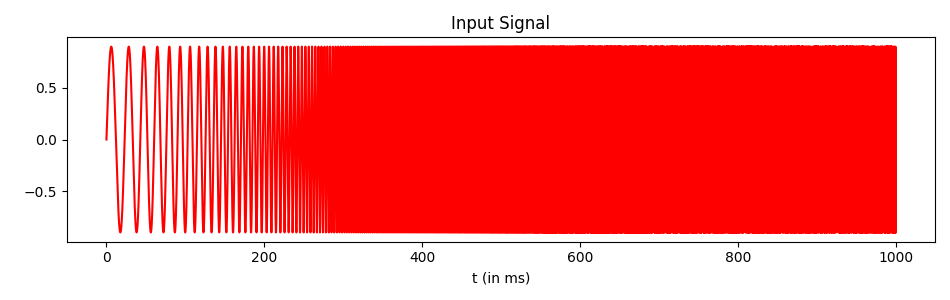

In [4]:
if fignum_exists(0): close(0)
figure(0, figsize=(w, 3))           # Sweep
plot(t1 * 500, stimulus, 'r')
xlabel('t (in ms)')
title('Input Signal');
tight_layout()

Now we define the number of cochlear filters and the range of Basilar Membrane positions to spread these filters over with equal spacing.

In [5]:
nsec  = 100                         # number of sections in the cochlea between
xlow  = 0.1                         # lowest frequency position along the cochlea and
xhigh = 0.9                         # highest frequency position along the cochlea

Once all these parameters are defined, we can calculate the parameters for the CAR model. The frequencies of the resonators are spaced according to the Greenwood formula, while the damping controls the poles. The choice of $h = c_0$ sets the zeros for each section about half an octave above the location of the poles. $g$ is calculated to provide 0dB gain at DC.

In [6]:
x = linspace(xhigh, xlow, nsec)     # position along the cochlea 1 = base, 0 = apex
f = 165.4 * (10**(2.1 * x) - 1)     # Greenwood for humans
a0 = cos(2 * pi * f / fs)           # a0 and c0 control the poles and zeros
c0 = sin(2 * pi * f / fs)

damping = 0.2                       # damping factor
r = 1 - damping * 2 * pi * f / fs   # pole & zero radius
h = c0                              # p285 h = c0 puts the zeros 1/2 octave above poles
g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)  
                                    # p285 this gives 0dB DC gain for BM


We also implement the Inner Hair Cell (IHC) model shown here:

<img src="./images/IHC.png" alt="IHC" style="width: 800px;"/>

First, the output of the BM filters is high-pass filtered at about 20Hz before being passed through a nonlinearity. A feedback loop provides  gain adaptation that causes the IHC to respond more strongly to the onset of a stimulus than the sustained part of that stimulus. Finally, the output of the IHC is low pass filtered to reduce the IHC's response to frequencies above 8kHz. 

In [7]:
f_hpf = 20                          # p313 20Hz corner for the BM HPF
q = 1 / (1 + (2 * pi * f_hpf / fs)) # corresponding IIR coefficient 

tau_in = 10e-3                      # p314 transmitter creation time constant
c_in = 1 / (fs * tau_in)            # p314 corresponding IIR coefficient    
tau_out = 0.5e-3                    # p314 transmitter depletion time constant
c_out = 1 / (fs * tau_out)          # p314 corresponding IIR coefficient 
tau_IHC = 80e-6                     # p314 ~8kHz LPF for IHC output
c_IHC = 1 / (fs * tau_IHC)          # p314 corresponding IIR coefficient 

Before we run the simulation, we initialise the variables as needed.

In [8]:
W0 = zeros(nsec)                    # BM filter internal state
W1 = zeros(nsec)                    # BM filter internal state
W1old = zeros(nsec)                 # BM filter internal state at t-1
BM = zeros((nsec, npoints))         # BM displacement
BM_hpf = zeros((nsec, npoints))     # BM displacement high-pass filtered at 20Hz
trans = ones(nsec)                  # transmitter available
IHC = zeros((nsec, npoints))        # IHC output
IHCa = zeros((nsec, npoints))       # IHC filter internal state
BM[-1] = stimulus                   # put stimulus at BM[-1] to provide input to BM[0]
BM[-1, -1] = 0                      # hack to make BM_hpf[nsec-1,0] work

Finally we simulate the whole system for each sample time and for all cochlear sections.

In [9]:
for t in range(npoints):
    for s in range(nsec):
        W0new = BM[s-1, t] + r[s] * (a0[s] * W0[s] - c0[s] * W1[s])
        W1[s] = r[s] * (a0[s] * W1[s] + c0[s] * W0[s])
        W0[s] = W0new
        BM[s, t] = g[s] * (BM[s-1, t] + h[s] * W1[s])
        
    BM_hpf[:,t] = q * (BM_hpf[:,t-1] + BM[:,t] - BM[:,t-1])
    z = (BM_hpf[:,t] + 0.175).clip(0)   # p313
    v_mem = z**3 / (z**3 + z**2 + 0.1)  # p313
    IHC_new = v_mem * trans             # p313
    trans += c_in * (1 - trans) - c_out * IHC_new   
    IHCa[:,t] = (1 - c_IHC) * IHCa[:, t-1] + c_IHC * IHC_new
    IHC[:,t] = (1 - c_IHC) * IHC[:, t-1] + c_IHC * IHCa[:,t]

After playing the sweep signal through the cochlea, i.e., using it as the stimulus and simulating all time steps, we can get the frequency response and phase response of each cochlear filter by calculating:

In [10]:
# play the stimulus through the system and measure the output
output = BM_hpf

# use the FFT of the stimulus and output directly to calculate the transfer function
myFFT = fft(zeros((nsec, npoints)))
for s in range(nsec):
    myFFT[s] = (fft(output[s]) / fft(stimulus))
    

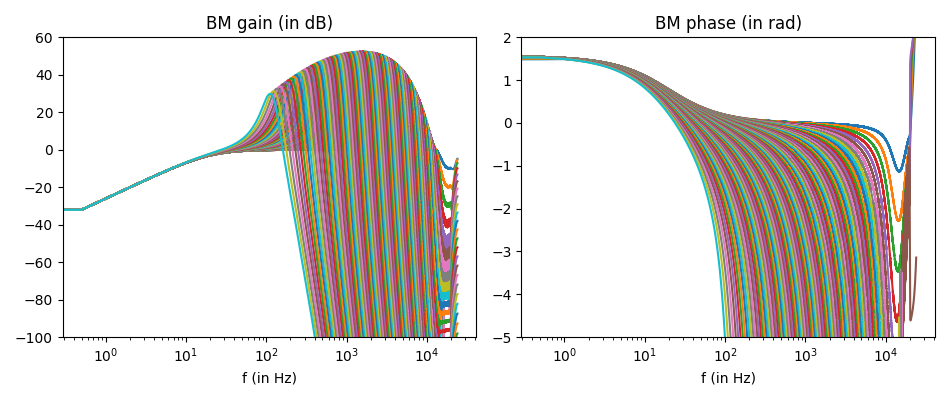

In [11]:
if fignum_exists(1): close(1)
fig = figure(1, figsize=(w, 4))     # Bode plot of BM displacement 
ax1 = subplot(1, 2, 1)
freq = linspace(0, fs // 2, (npoints) // 2)
semilogx(freq, 20 * log10(abs(myFFT.T[0 : npoints // 2, :]) + 1e-10))  
# note, 1e-10 offset above to avoid division by zero in log10
title('BM gain (in dB)')
ylim([-100, 60])
xlabel('f (in Hz)')
ax2 = subplot(1, 2, 2, sharex = ax1)
semilogx(freq, unwrap(angle(myFFT.T[0 : npoints // 2, :]), discont = 5, axis = 0))
title('BM phase (in rad)')
ylim([-5, 2])
xlabel('f (in Hz)')
tight_layout()

From this, we can also determine the impulse response of each filter.

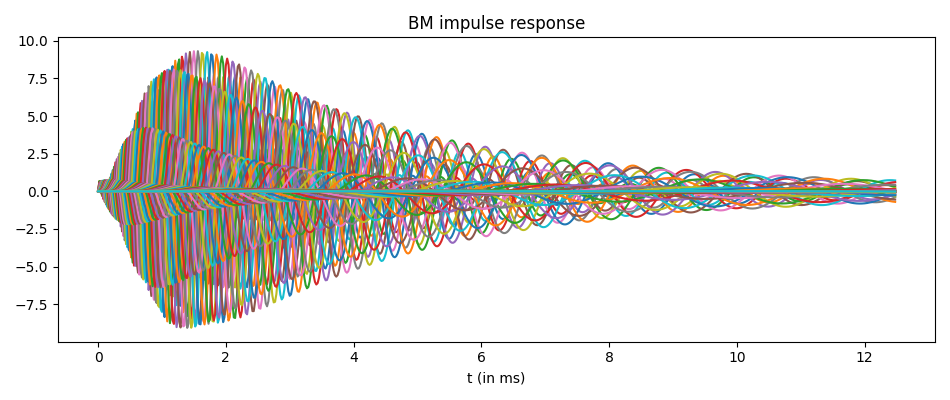

In [12]:
# calculate the BM impulse response
IR = real(ifft(myFFT))
IR[:, 0] = zeros(nsec)              # remove artefact

if fignum_exists(2): close(2)
figure(2, figsize=(w, 4))           # BM impulse response
L=600
plot(arange(L) * 1000 / fs, IR[:, 0 : L].T)
xlabel('t (in ms)')
title('BM impulse response')
tight_layout()

Finally, we plot the output of the IHC.

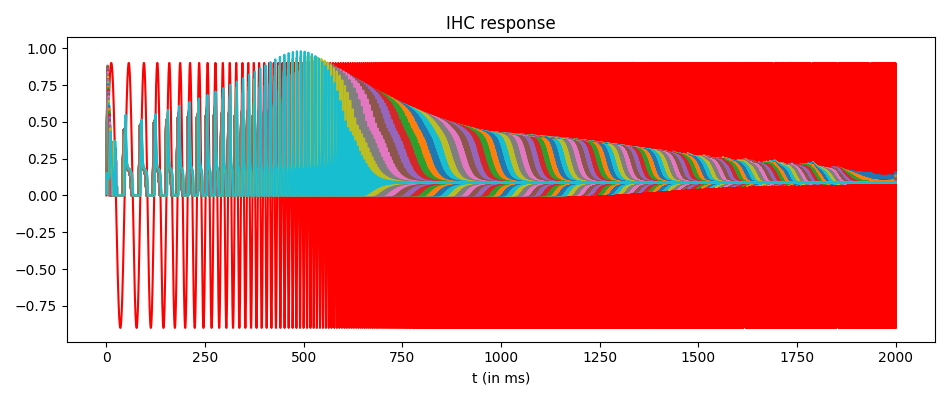

In [13]:
if fignum_exists(3): close(3)
figure(3, figsize=(w, 4))           # IHC output
plot(t1 * 1000, stimulus, 'r')
plot(t1 * 1000, IHC.T * 4.0)
xlabel('t (in ms)')
title('IHC response')
tight_layout()

Note that at the start of the sweep, i.e., for the lowest input frequencies, you can clearly see the stronger response of the IHC to the start of the positive excursion of the sine wave, than to the later part. Also, as the sweep moves through the frequencies, one IHC after another reaches a maximum response, depending on which cochlear channel they are attached to. If we zoom in around 500ms we see this more clearly, with first the green channel, then the blue channel, and then the black channel (etc.) having the strongest response.

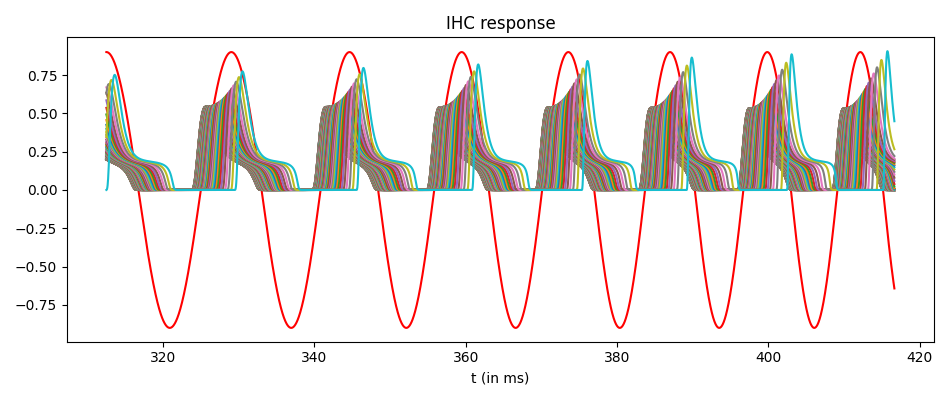

In [14]:
if fignum_exists(4): close(4)
figure(4, figsize=(w, 4))           # IHC output
plot(t1[15000 : 20000] * 1000, stimulus[15000 : 20000], 'r')
plot(t1[15000 : 20000] * 1000, IHC[:, 15000 : 20000].T * 4.0)
xlabel('t (in ms)')
title('IHC response')
tight_layout()

In [15]:
# If true then scrolling while the mouse is over the canvas will not move the entire notebook
fig = gcf()
fig.canvas.capture_scroll = True